# Variational Bayes under model misspecification

This notebook explores the performance of variational inference (VI; syn. variational Bayes) under model misspecification, as described in
>**Wang, Y. & Blei, D. M. Variational Bayes under Model Misspeciﬁcation. 2020. https://arxiv.org/abs/1905.10859.**

This code implements the model misspecification scenario described in section *C.2 Component misspecification in Bayesian mixture models* from the appendix of this paper:
>"Suppose the data is generated by a Bayesian mixture model where each component is Gaussian and shares the same variance. But we fit a Bayesian mixture model where each component is a t-distribution."

Following the methods in this paper, two algorithms are used to estimate model parameters: automatic differentiation variational inference (ADVI) for VI and No-U-Turn sampler (NUTS) for Hamiltonian Monte Carlo.

Jacqueline Maasch | April 2023

## Preamble

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import time
from scipy import stats
import warnings

# Stan-related importations.
import cmdstanpy
from cmdstanpy import CmdStanModel
import arviz as az
import nest_asyncio # https://pystan.readthedocs.io/en/latest/faq.html
nest_asyncio.apply()

# View versioning.
print("python version     :", platform.python_version())
print("numpy version      :", np.__version__)
print("pandas version     :", pd.__version__)
print("matplotlib version :", matplotlib.__version__)
print("seaborn version    :", sns.__version__)
print("cmdstanpy version  :", cmdstanpy.__version__)

python version     : 3.10.2
numpy version      : 1.22.2
pandas version     : 1.4.1
matplotlib version : 3.5.1
seaborn version    : 0.12.2
cmdstanpy version  : 1.1.0


In [2]:
# For cmdstanpy progress bars.
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
'''
Must also install cmdstan.
If this produces an SSL certificate verification errorr, locate the file 
"Install Certificates.command" and double click to run this script first.
https://stackoverflow.com/questions/52805115/certificate-verify-failed-unable-to-get-local-issuer-certificate
'''
#from cmdstanpy import install_cmdstan
#install_cmdstan(verbose = True)

'\nMust also install cmdstan.\nIf this produces an SSL certificate verification errorr, locate the file \n"Install Certificates.command" and double click to run this script first.\nhttps://stackoverflow.com/questions/52805115/certificate-verify-failed-unable-to-get-local-issuer-certificate\n'

## Generate data from a mixture of Gaussians

Under the true generating process, data are sampled from a mixture of two Gaussians with equal variance.

In [4]:
# Total samples.
n = 10000

# Gaussian component means vary but standard deviations are equal.
#mu = np.random.uniform(1, 10, 2)
#sigma = np.random.uniform(1, 5, 1)
mu = np.array([1.25, 4.75])
sigma = np.array([1.5])

# Mixture membership is the result of a Bernoulli trial.
# Each component is equally probable.
p = 0.5
mixture_id = stats.bernoulli.rvs(p, size = n)

# Each observation is drawn from the normal to which it was assigned.
# Note that scale = sd, not var.
y_true = stats.norm.rvs(loc = mu[mixture_id], scale = sigma, size = n)
df = pd.DataFrame({"Component ID": mixture_id, 
                   "Ground truth": y_true})
df["Component mean"] = df["Component ID"].map(lambda x: mu[x])

In [5]:
# Examine distributions.
print("-*- Component 0 -*-")
print("Ground truth mean :", mu[0])
print("Sample mean       :", df[df["Component ID"] == 0]["Ground truth"].mean())
print("Ground truth SD   :", *sigma)
print("Sample SD         :", df[df["Component ID"] == 0]["Ground truth"].std())

print("\n-*- Component 1 -*-")
print("Ground truth mean :", mu[1])
print("Sample mean       :", df[df["Component ID"] == 1]["Ground truth"].mean())
print("Ground truth SD   :", *sigma)
print("Sample SD         :", df[df["Component ID"] == 1]["Ground truth"].std(), "\n")

display(df)

-*- Component 0 -*-
Ground truth mean : 1.25
Sample mean       : 1.277697229180095
Ground truth SD   : 1.5
Sample SD         : 1.5118589997405647

-*- Component 1 -*-
Ground truth mean : 4.75
Sample mean       : 4.765968650225095
Ground truth SD   : 1.5
Sample SD         : 1.510466486371465 



,Component ID,Ground truth,Component mean
0,1,4.695816,4.75
1,1,6.195646,4.75
2,1,4.270369,4.75
3,1,5.305967,4.75
4,0,0.309206,1.25
...,...,...,...
9995,1,5.125217,4.75
9996,0,0.150930,1.25
9997,1,3.015853,4.75
9998,0,0.948704,1.25


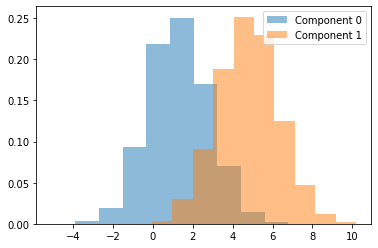

In [6]:
plt.hist(df[df["Component ID"] == 0]["Ground truth"], alpha = 0.5, label = "Component 0", density = True)
plt.hist(df[df["Component ID"] == 1]["Ground truth"], alpha = 0.5, label = "Component 1", density = True)
plt.legend(loc = "upper right")
plt.show()

## Stan model configurations

In [7]:
# Place data in dictionary for Stan models.
stan_data = {"N": df.shape[0], 
             "y": df["Ground truth"].values}

# Filter warnings?
warnings_setting = "ignore" # "once"

# Sampling parameters.
n_fit = 5000
n_warmup = 500
n_chains = 2

## Correctly specified mixture model

First, we will fit a correctly specified Stan model to compare against the misspecified model. This model will be fit using MCMC and VI.

### Define model

In [8]:
stan_folder = "./"
stan_file = stan_folder + "mixture_model_correctly_specified.stan"
with open(stan_file) as file:
    correct_model = file.read()
print(correct_model)

data {
    int<lower=0> N;
    vector[N] y;
}

parameters {
    vector[2] mu;
    real<lower=0> sigma;
    real<lower=0,upper=1> theta;
}

/*
Model data as Gaussian mixture where components have equal variance.
*/
model {
    sigma ~ normal(2, 2);
    mu[1] ~ normal(1, 1);
    mu[2] ~ normal(5, 1);
    theta ~ beta(1, 1);
    for (n in 1:N)
        target += log_mix(theta,
                          normal_lpdf(y[n] | mu[1], sigma),
                          normal_lpdf(y[n] | mu[2], sigma));
}

/*
Draw samples from the posterior predictive distribution to check fit.
*/
generated quantities {

    array[N] real y_posterior_pred;
    array[N] int component_id_pred;
    
    for(n in 1:N){
    
        // Predict component membership.
        component_id_pred[n] = bernoulli_rng(theta);
        
        // Sample from posterior.
        y_posterior_pred[n] = normal_rng(mu[component_id_pred[n] + 1], sigma);
    }
    
}


### Compile

In [9]:
# Compile model.
correct_model_compiled = CmdStanModel(stan_file = "mixture_model_correctly_specified.stan")

### Fit with MCMC

This sampling method invokes Stan’s adaptive **HMC-NUTS** sampler, which uses the **Hamiltonian Monte Carlo (HMC) algorithm** and its **adaptive variant the no-U-turn sampler (NUTS)**. This yields a set of samples from the posterior distribution of the model parameters conditioned on the data.

Read more in the `CmdStanPy` [docs](https://cmdstanpy.readthedocs.io/en/stable-0.9.65/sample.html).

In [10]:
# Fit correctly specified model.
start = time.time()
correct_model_fit_hmc = correct_model_compiled.sample(data = stan_data, 
                                                      chains = n_chains, 
                                                      iter_warmup = n_warmup, 
                                                      iter_sampling = n_fit)
print("HMC-NUTS complete in {} seconds.".format(round(time.time() - start, 3)))

16:16:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

16:19:24 - cmdstanpy - INFO - CmdStan done processing.



HMC-NUTS complete in 165.97 seconds.


In [12]:
# View model summary.
correct_model_summary_hmc = az.summary(correct_model_fit_hmc)
display(correct_model_summary_hmc)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_s

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],1.273,0.035,1.208,1.340,0.000,0.000,5673.0,6700.0,1.0
mu[1],4.764,0.035,4.698,4.831,0.000,0.000,6072.0,6563.0,1.0
sigma,1.509,0.017,1.477,1.542,0.000,0.000,7386.0,6496.0,1.0
theta,0.504,0.009,0.487,0.520,0.000,0.000,5606.0,6479.0,1.0
y_posterior_pred[0],3.042,2.307,-1.158,7.042,0.023,0.016,9553.0,10007.0,1.0
...,...,...,...,...,...,...,...,...,...
component_id_pred[9995],0.492,0.500,0.000,1.000,0.005,0.004,9618.0,9618.0,1.0
component_id_pred[9996],0.503,0.500,0.000,1.000,0.005,0.004,9919.0,9919.0,1.0
component_id_pred[9997],0.501,0.500,0.000,1.000,0.005,0.004,9812.0,9812.0,1.0
component_id_pred[9998],0.499,0.500,0.000,1.000,0.005,0.003,10252.0,10000.0,1.0


array([[<AxesSubplot:title={'center':'mu\n0'}>,
        <AxesSubplot:title={'center':'mu\n0'}>],
       [<AxesSubplot:title={'center':'mu\n1'}>,
        <AxesSubplot:title={'center':'mu\n1'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

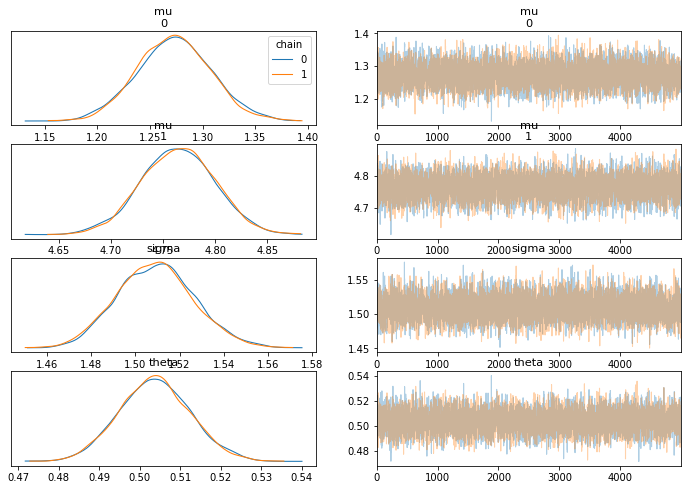

In [13]:
az.plot_trace(correct_model_fit_hmc, 
              var_names = ("mu", "sigma", "theta"),
              compact = False, 
              legend = True)

array([<AxesSubplot:title={'center':'mu\n0'}>,
       <AxesSubplot:title={'center':'mu\n1'}>,
       <AxesSubplot:title={'center':'sigma'}>,
       <AxesSubplot:title={'center':'theta'}>], dtype=object)

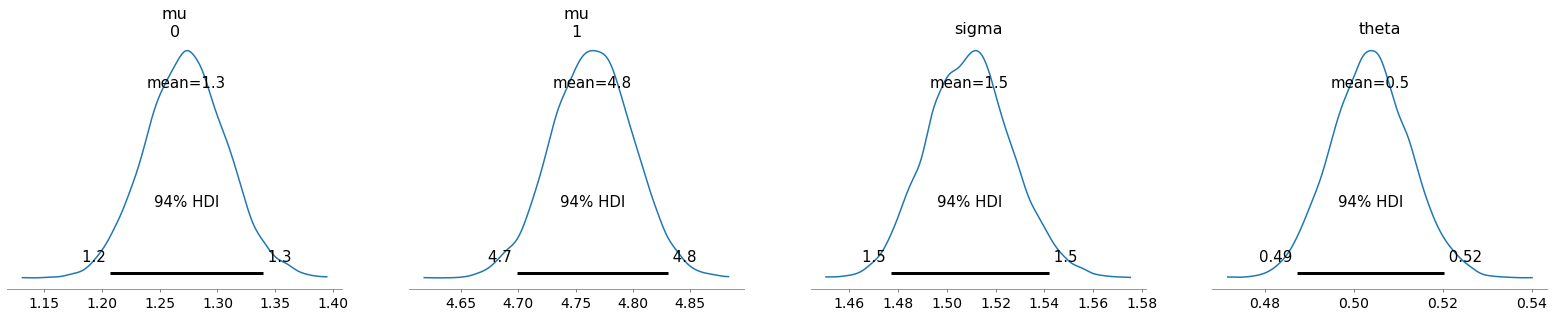

In [14]:
# Plot model posterior.
correct_model_idata_hmc = az.from_cmdstanpy(posterior = correct_model_fit_hmc)
az.plot_posterior(correct_model_idata_hmc, var_names = ("mu", "sigma", "theta"))

### Fit with variational inference

>Stan implements an **automatic variational inference** algorithm, called **Automatic Differentiation Variational Inference (ADVI)** which searches over a family of simple densities to find the best approximate posterior density. ADVI produces an estimate of the parameter means together with a sample from the approximate posterior density. ADVI approximates the variational objective function, the **evidence lower bound or ELBO**, using **stochastic gradient ascent**.

Read more in the `CmdStanPy` [docs](https://cmdstanpy.readthedocs.io/en/stable-0.9.65/variational_bayes.html).

In [15]:
# Fit correctly specified model.
start = time.time()
correct_model_fit_advi = correct_model_compiled.variational(data = stan_data, 
                                                            output_samples = n_fit, 
                                                            algorithm = "meanfield", 
                                                            iter = 1000,
                                                            grad_samples = 20)
print("Variational inference complete in {} seconds.".format(round(time.time() - start, 3)))

16:26:20 - cmdstanpy - INFO - Chain [1] start processing
16:27:33 - cmdstanpy - INFO - Chain [1] done processing


Variational inference complete in 117.328 seconds.


In [16]:
# View parameters as estimated by ADVI.
display(correct_model_fit_advi.variational_params_pd[["lp__", "log_p__", "log_g__", "mu[1]", "mu[2]", "sigma", "theta"]])
display(correct_model_fit_advi.variational_sample_pd[["lp__", "log_p__", "log_g__", "mu[1]", "mu[2]", "sigma", "theta"]])

,lp__,log_p__,log_g__,mu[1],mu[2],sigma,theta
0,0.0,0.0,0.0,1.25048,4.78036,1.54488,0.506787


,lp__,log_p__,log_g__,mu[1],mu[2],sigma,theta
0,0.0,-22355.5,-2.513550,1.24965,4.75397,1.52601,0.497256
1,0.0,-22361.2,-0.581674,1.23107,4.78467,1.54104,0.511177
2,0.0,-22361.5,-3.429430,1.23176,4.71845,1.55271,0.508143
3,0.0,-22360.1,-0.338086,1.24639,4.79696,1.54166,0.509383
4,0.0,-22359.9,-0.815185,1.22773,4.77319,1.53521,0.510431
...,...,...,...,...,...,...,...
4995,0.0,-22363.3,-1.687780,1.24841,4.78402,1.55154,0.517874
4996,0.0,-22358.3,-2.883050,1.26176,4.82614,1.52333,0.509476
4997,0.0,-22365.6,-2.993510,1.22012,4.73808,1.55824,0.513004
4998,0.0,-22356.5,-2.753550,1.28837,4.80877,1.52825,0.512384


In [17]:
%%capture
'''
# Note: I could not get any of this to work.

# View model summary.
advi_data = az.convert_to_dataset(correct_model_fit_advi)
correct_model_summary_advi = az.summary(advi_data)
display(correct_model_summary_advi)

az.plot_trace(correct_model_fit_advi, 
              var_names = ("mu", "sigma", "theta"),
              compact = False, 
              legend = True)
              
# Plot model posterior.
correct_model_idata_advi = az.from_cmdstanpy(posterior = correct_model_fit_advi)
az.plot_posterior(correct_model_idata_advi, var_names = ("mu", "sigma", "theta"))
'''

### Posterior predictive check

#### MCMC

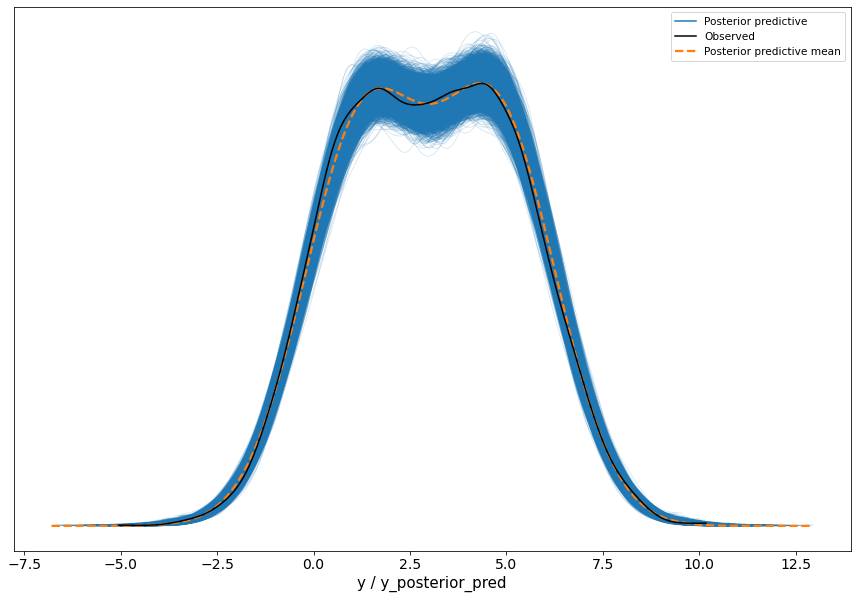

In [18]:
plt.rcParams["figure.figsize"] = (15, 10)
correct_model_hmc_ppc_data = az.from_cmdstanpy(posterior = correct_model_fit_hmc,
                                               posterior_predictive = ["y_posterior_pred"], 
                                               observed_data = {"y": df["Ground truth"].values})
ax = az.plot_ppc(data = correct_model_hmc_ppc_data, 
                 data_pairs = {"y": "y_posterior_pred"})
plt.show()
plt.close()

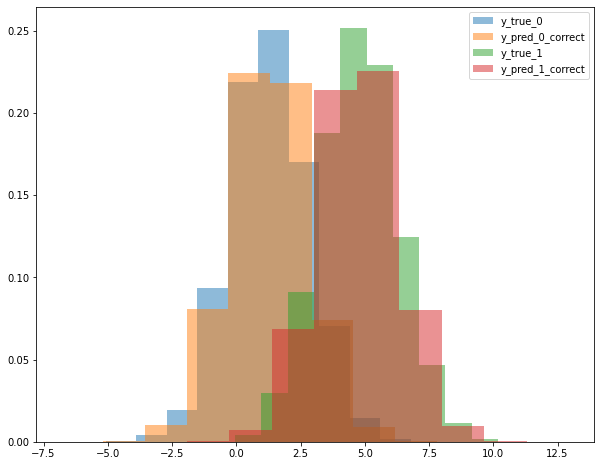

In [19]:
# Extract ground truth and predicted component memberships.
component_true = df["Component ID"].values
component_pred_correct_hmc = correct_model_idata_hmc.posterior.component_id_pred.values.flatten()

# Extract ground truth values for each mixture component.
y_true_0 = df[df["Component ID"] == 0]["Ground truth"].values
y_true_1 = df[df["Component ID"] == 1]["Ground truth"].values

# Extract predicted values for each mixture component.
y_pred_correct_hmc = correct_model_idata_hmc.posterior.y_posterior_pred.values
y_pred_correct_hmc = y_pred_correct_hmc.flatten()
y_pred_0_correct_hmc = y_pred_correct_hmc[~component_pred_correct_hmc.astype(bool)]
y_pred_1_correct_hmc = y_pred_correct_hmc[component_pred_correct_hmc.astype(bool)]

# Plot ground truth vs predictions for each mixture component.
plt.rcParams["figure.figsize"] = (10,8)
plt.hist(y_true_0, alpha = 0.5, label = "y_true_0", density = True)
plt.hist(y_pred_0_correct_hmc, alpha = 0.5, label = "y_pred_0_correct", density = True)
plt.hist(y_true_1, alpha = 0.5, label = "y_true_1", density = True)
plt.hist(y_pred_1_correct_hmc, alpha = 0.5, label = "y_pred_1_correct", density = True)
plt.legend(loc = "upper right")
plt.show()

In [20]:
np.unique(component_pred_correct_hmc, return_counts = True)

(array([0., 1.]), array([49623963, 50376037]))

#### Variational inference

In [21]:
%%capture
'''
# Note: I could not get this to work.

plt.rcParams["figure.figsize"] = (15, 10)
correct_model_advi_ppc_data = az.from_cmdstanpy(posterior = correct_model_fit_advi,
                                               posterior_predictive = ["y_posterior_pred"], 
                                               observed_data = {"y": df["Ground truth"].values})
ax = az.plot_ppc(data = correct_model_advi_ppc_data, 
                 data_pairs = {"y": "y_posterior_pred"})
plt.show()
plt.close()
'''

In [22]:
# Extract ADVI results.
posterior_cols = []
for col in correct_model_fit_advi.variational_sample_pd.columns:
    if "posterior" in col:
        posterior_cols.append(col)

component_cols = []
for col in correct_model_fit_advi.variational_sample_pd.columns:
    if "component" in col:
        component_cols.append(col)

print(len(posterior_cols))
print(len(component_cols))

advi_posterior_pred = correct_model_fit_advi.variational_sample_pd[posterior_cols].to_numpy().flatten()
advi_component_pred = correct_model_fit_advi.variational_sample_pd[component_cols].to_numpy().flatten()
print(advi_posterior_pred.shape)
print(advi_posterior_pred[:10])
print(advi_component_pred.shape)
print(advi_component_pred[:10])

10000
10000
(50000000,)
[5.64434   5.13268   0.667408  2.17006   1.92115   6.75882   0.0643884
 3.83275   4.23675   5.22068  ]
(50000000,)
[1. 1. 1. 0. 0. 1. 0. 1. 1. 1.]


,lp__,log_p__,log_g__,mu[1],mu[2],sigma,theta
0,0.0,0.0,0.0,1.25048,4.78036,1.54488,0.506787


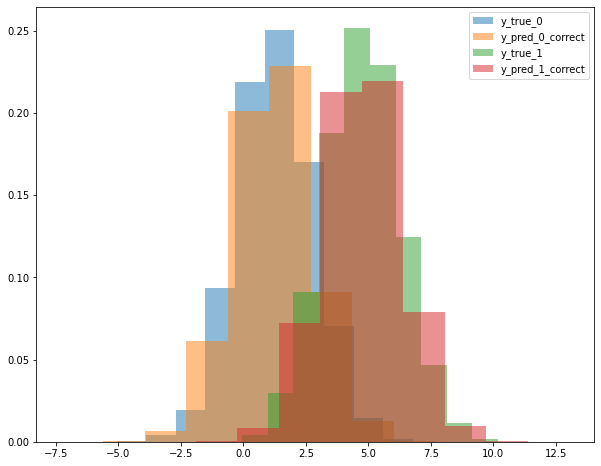

In [23]:
# View parameters as estimated by ADVI.
display(correct_model_fit_advi.variational_params_pd[["lp__", "log_p__", "log_g__", "mu[1]", "mu[2]", "sigma", "theta"]])

# Extract ground truth and predicted component memberships.
component_true = df["Component ID"].values
component_pred_correct_advi = advi_component_pred

# Extract ground truth values for each mixture component.
y_true_0 = df[df["Component ID"] == 0]["Ground truth"].values
y_true_1 = df[df["Component ID"] == 1]["Ground truth"].values

# Extract predicted values for each mixture component.
y_pred_correct_advi = advi_posterior_pred
y_pred_0_correct_advi = y_pred_correct_advi[~component_pred_correct_advi.astype(bool)]
y_pred_1_correct_advi = y_pred_correct_advi[component_pred_correct_advi.astype(bool)]

# Plot ground truth vs predictions for each mixture component.
plt.rcParams["figure.figsize"] = (10,8)
plt.hist(y_true_0, alpha = 0.5, label = "y_true_0", density = True)
plt.hist(y_pred_0_correct_advi, alpha = 0.5, label = "y_pred_0_correct", density = True)
plt.hist(y_true_1, alpha = 0.5, label = "y_true_1", density = True)
plt.hist(y_pred_1_correct_advi, alpha = 0.5, label = "y_pred_1_correct", density = True)
plt.legend(loc = "upper right")
plt.show()

#### MCMC vs VI

In [41]:
round_by = 3

# Compare predicted component means to ground truth.
mu_0_pred_correct_hmc = [i[:,0] for i in correct_model_idata_hmc.posterior.mu.values]
mu_0_pred_correct_hmc = np.array(mu_0_pred_correct_hmc).flatten()
mu_1_pred_correct_hmc = [i[:,1] for i in correct_model_idata_hmc.posterior.mu.values]
mu_1_pred_correct_hmc = np.array(mu_1_pred_correct_hmc).flatten()

print("\n-*- Component 0 -*-")
print("True mean      :", mu[0])
print("HMC-NUTS mean  : {} (SD = {})".format(round(mu_0_pred_correct_hmc.mean(), round_by), 
                                             round(mu_0_pred_correct_hmc.std(), round_by)))
print("ADVI mean      : {} (SD = {})".format(round(correct_model_fit_advi.variational_sample_pd["mu[1]"].mean(), round_by), 
                                             round(correct_model_fit_advi.variational_sample_pd["mu[1]"].std(), round_by)))

print("\n-*- Component 1 -*-")
print("True mean      :", mu[1])
print("HMC-NUTS mean  : {} (SD = {})".format(round(mu_1_pred_correct_hmc.mean(), round_by), 
                                             round(mu_1_pred_correct_hmc.std(), round_by)))
print("ADVI mean      : {} (SD = {})".format(round(correct_model_fit_advi.variational_sample_pd["mu[2]"].mean(), round_by), 
                                             round(correct_model_fit_advi.variational_sample_pd["mu[2]"].std(), round_by)))


-*- Component 0 -*-
True mean      : 1.25
HMC-NUTS mean  : 1.273 (SD = 0.035)
ADVI mean      : 1.25 (SD = 0.026)

-*- Component 1 -*-
True mean      : 4.75
HMC-NUTS mean  : 4.764 (SD = 0.035)
ADVI mean      : 4.781 (SD = 0.025)


## Misspecified mixture model

### Define model

In [25]:
stan_folder = "./"
stan_file = stan_folder + "mixture_model_misspecified.stan"
with open(stan_file) as file:
    misspecified_model = file.read()
print(misspecified_model)

data {
    int<lower=0> N;
    vector[N] y;
}

/*
Mixture model parameters when components are t-distributions:
- mu: location.
- nu: degrees of freedom.
- sigma: scale.
- theta: probability that component ID = 1.
*/
parameters {
    vector[2] mu;
    real<lower=1,upper=100> nu;
    real<lower=0> sigma;
    real<lower=0,upper=1> theta;
}

/*
Model components as t-distributions with equal variance and degrees of freedom.

The prior distribution for degrees of freedom was selected based on:
https://en.wikipedia.org/wiki/Student%27s_t-distribution#Bayesian_inference:_prior_distribution_for_the_degrees_of_the_freedom
*/
model {
    sigma ~ normal(2, 2);
    mu[1] ~ normal(1, 1);
    mu[2] ~ normal(5, 1);
    theta ~ beta(1, 1);
    nu ~ lognormal(1, 1);
    for (n in 1:N)
        target += log_mix(theta,
                          student_t_lpdf(y[n] | nu, mu[1], sigma),
                          student_t_lpdf(y[n] | nu, mu[2], sigma));
}

/*
Draw samples from the posterior predictive dist

### Compile

In [26]:
# Compile model.
#warnings.filterwarnings(warnings_setting)
misspecified_model_compiled = CmdStanModel(stan_file = "mixture_model_misspecified.stan")

### Fit with MCMC

This sampling method invokes Stan’s adaptive **HMC-NUTS** sampler, which uses the **Hamiltonian Monte Carlo (HMC) algorithm** and its **adaptive variant the no-U-turn sampler (NUTS)**. This yields a set of samples from the posterior distribution of the model parameters conditioned on the data.

Read more in the `CmdStanPy` [docs](https://cmdstanpy.readthedocs.io/en/stable-0.9.65/sample.html).

In [27]:
# Fit misspecified model.
start = time.time()
misspecified_model_fit_hmc = misspecified_model_compiled.sample(data = stan_data, 
                                                                chains = n_chains, 
                                                                iter_warmup = n_warmup, 
                                                                iter_sampling = n_fit)
print("HMC-NUTS complete in {} seconds.".format(round(time.time() - start, 3)))

16:30:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1389d2ce0>


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1389d2e00>
16:35:44 - cmdstanpy - INFO - CmdStan done processing.
16:35:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in '/Users/jacquelinemaasch/Desktop/CORNELL/__spring2023/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
	Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in '/Users/jacquelinemaasch/Desktop/CORNELL/__spring2023/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
	Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in '/Users/jacquelinemaasch/Desktop/CORNELL/__spring2023/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
	Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite


HMC-NUTS complete in 343.064 seconds.


In [28]:
# View model summary.
misspecified_model_summary_hmc = az.summary(misspecified_model_fit_hmc)
display(misspecified_model_summary_hmc)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_s

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],1.273,0.035,1.205,1.338,0.000,0.000,4981.0,6133.0,1.0
mu[1],4.760,0.035,4.695,4.826,0.000,0.000,5078.0,6134.0,1.0
nu,49.375,16.769,23.436,83.322,0.280,0.215,4282.0,2876.0,1.0
sigma,1.479,0.019,1.443,1.516,0.000,0.000,6804.0,6400.0,1.0
theta,0.503,0.009,0.487,0.520,0.000,0.000,4382.0,5486.0,1.0
...,...,...,...,...,...,...,...,...,...
component_id_pred[9995],0.502,0.500,0.000,1.000,0.005,0.004,9373.0,9373.0,1.0
component_id_pred[9996],0.506,0.500,0.000,1.000,0.005,0.004,9793.0,9793.0,1.0
component_id_pred[9997],0.505,0.500,0.000,1.000,0.005,0.004,9671.0,9671.0,1.0
component_id_pred[9998],0.508,0.500,0.000,1.000,0.005,0.004,9872.0,9872.0,1.0


array([[<AxesSubplot:title={'center':'mu\n0'}>,
        <AxesSubplot:title={'center':'mu\n0'}>],
       [<AxesSubplot:title={'center':'mu\n1'}>,
        <AxesSubplot:title={'center':'mu\n1'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

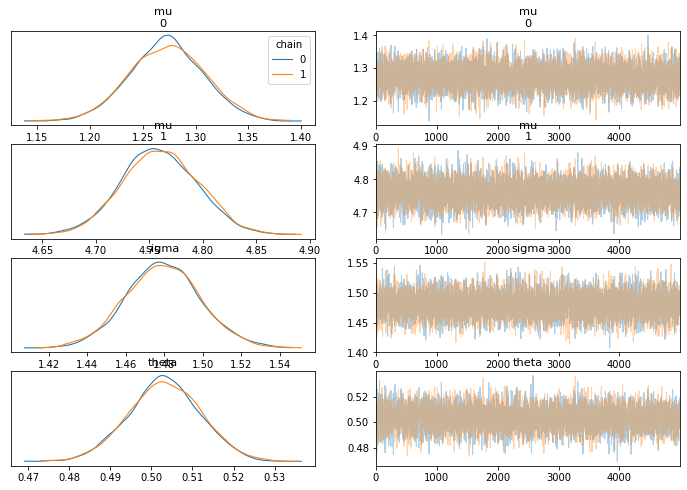

In [29]:
az.plot_trace(misspecified_model_fit_hmc, 
              var_names = ("mu", "sigma", "theta"),
              compact = False, 
              legend = True)

array([<AxesSubplot:title={'center':'mu\n0'}>,
       <AxesSubplot:title={'center':'mu\n1'}>,
       <AxesSubplot:title={'center':'sigma'}>,
       <AxesSubplot:title={'center':'theta'}>], dtype=object)

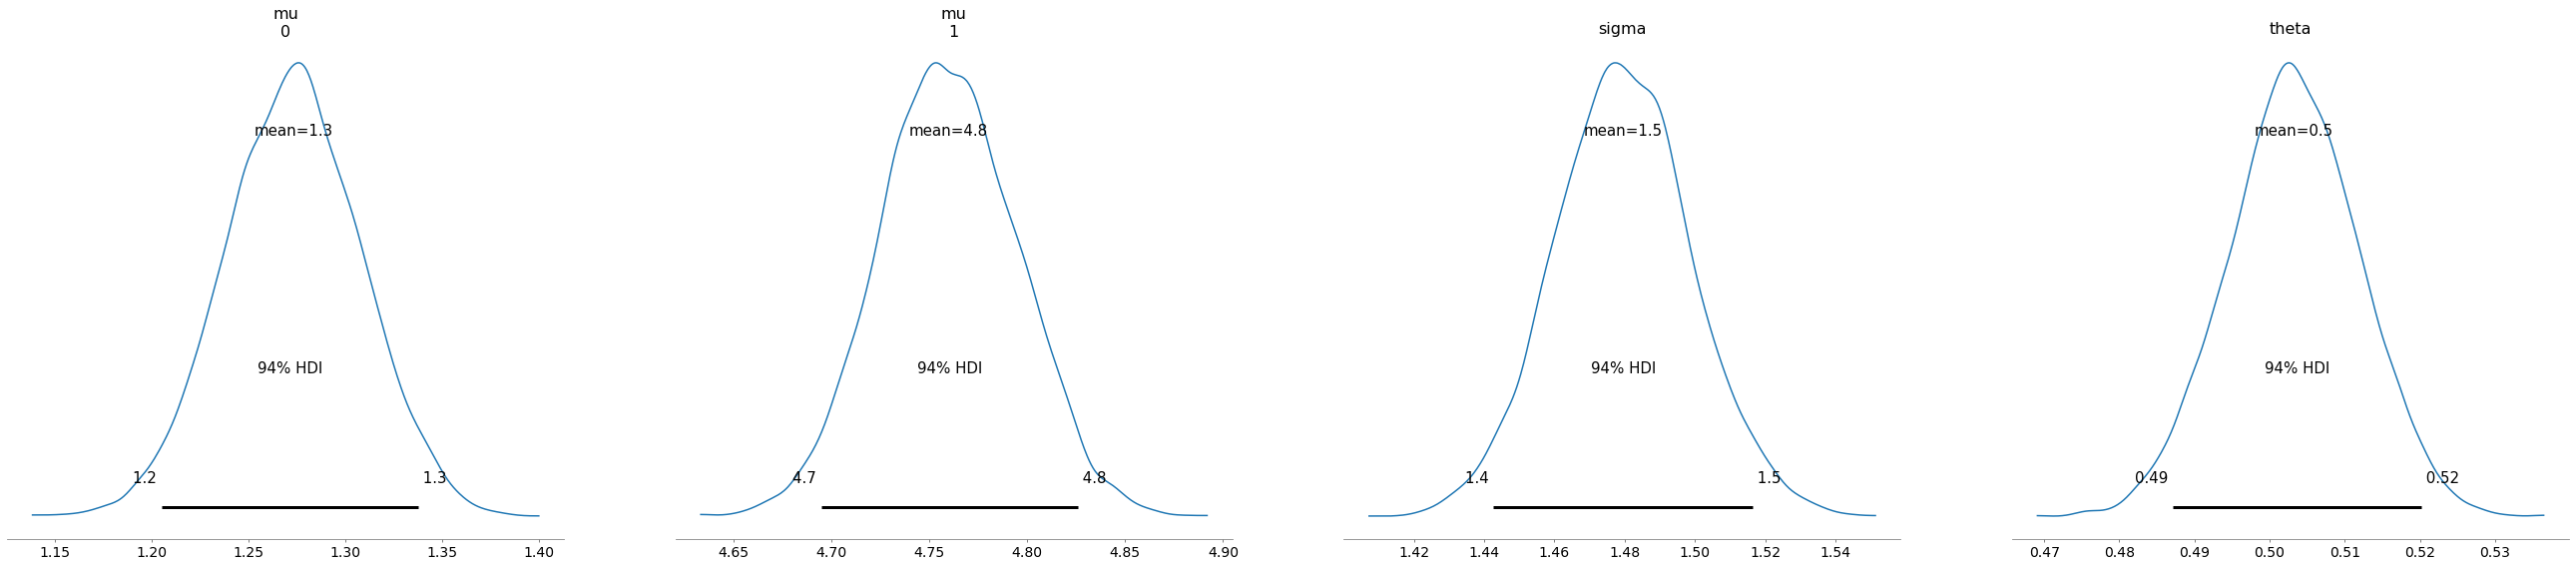

In [30]:
# Plot misspecified model posterior.
misspecified_model_idata_hmc = az.from_cmdstanpy(posterior = misspecified_model_fit_hmc)
az.plot_posterior(misspecified_model_idata_hmc, var_names = ("mu", "sigma", "theta"))

### Fit with variational inference

>Stan implements an **automatic variational inference** algorithm, called **Automatic Differentiation Variational Inference (ADVI)** which searches over a family of simple densities to find the best approximate posterior density. ADVI produces an estimate of the parameter means together with a sample from the approximate posterior density. ADVI approximates the variational objective function, the **evidence lower bound or ELBO**, using **stochastic gradient ascent**.

Read more in the `CmdStanPy` [docs](https://cmdstanpy.readthedocs.io/en/stable-0.9.65/variational_bayes.html).

In [31]:
# Fit misspecified model.
start = time.time()
misspecified_model_fit_advi = misspecified_model_compiled.variational(data = stan_data, 
                                                            output_samples = n_fit, 
                                                            algorithm = "meanfield", 
                                                            iter = 1000,
                                                            grad_samples = 20)
print("Variational inference complete in {} seconds.".format(round(time.time() - start, 3)))

16:39:51 - cmdstanpy - INFO - Chain [1] start processing
16:41:27 - cmdstanpy - INFO - Chain [1] done processing


Variational inference complete in 146.208 seconds.


In [42]:
# View parameters as estimated by ADVI.
display(misspecified_model_fit_advi.variational_params_pd[["lp__", "log_p__", "log_g__", "mu[1]", "mu[2]", "sigma", "theta", "nu"]])
display(misspecified_model_fit_advi.variational_sample_pd[["lp__", "log_p__", "log_g__", "mu[1]", "mu[2]", "sigma", "theta", "nu"]])

,lp__,log_p__,log_g__,mu[1],mu[2],sigma,theta,nu
0,0.0,0.0,0.0,1.29725,4.72574,1.44025,0.507425,45.996


,lp__,log_p__,log_g__,mu[1],mu[2],sigma,theta,nu
0,0.0,-22374.7,-6.125700,1.30076,4.75622,1.40682,0.493340,35.9125
1,0.0,-22368.2,-1.004910,1.30790,4.70500,1.44456,0.503473,36.9644
2,0.0,-22368.4,-1.536030,1.31789,4.75857,1.43056,0.511042,40.4680
3,0.0,-22367.0,-0.426038,1.27662,4.72610,1.43763,0.509019,42.0471
4,0.0,-22362.8,-2.663890,1.28057,4.74115,1.44619,0.508004,25.7964
...,...,...,...,...,...,...,...,...
4995,0.0,-22376.8,-1.857730,1.30218,4.67876,1.43584,0.511401,41.1597
4996,0.0,-22373.2,-1.546290,1.28931,4.73835,1.42597,0.514506,54.1600
4997,0.0,-22376.7,-2.233650,1.28755,4.73927,1.41326,0.509398,56.8147
4998,0.0,-22371.6,-2.267120,1.28135,4.74050,1.41221,0.508764,37.7038


### Posterior predictive check

#### MCMC

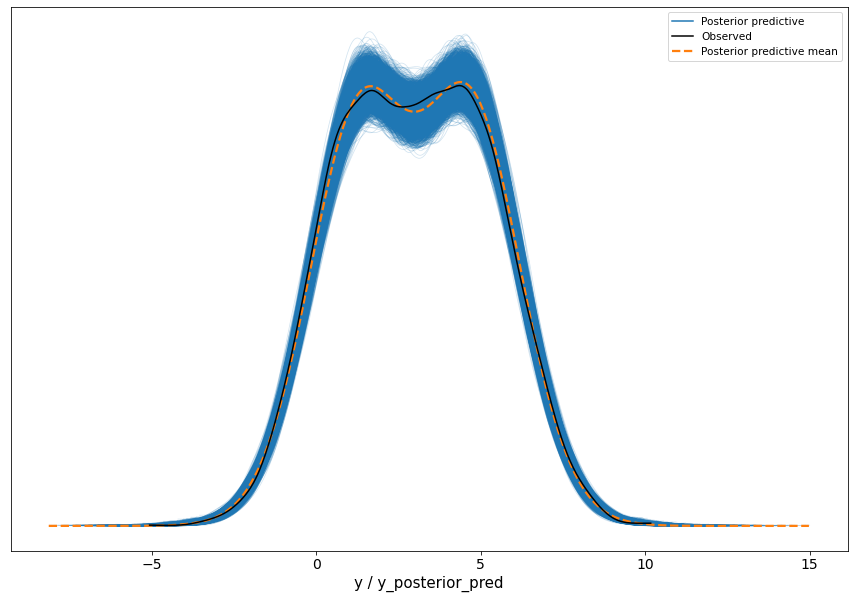

In [33]:
plt.rcParams["figure.figsize"] = (15, 10)
misspecified_model_hmc_ppc_data = az.from_cmdstanpy(posterior = misspecified_model_fit_hmc,
                                                    posterior_predictive = ["y_posterior_pred"], 
                                                    observed_data = {"y": df["Ground truth"].values})
ax = az.plot_ppc(data = misspecified_model_hmc_ppc_data, 
                 data_pairs = {"y": "y_posterior_pred"})
plt.show()
plt.close()

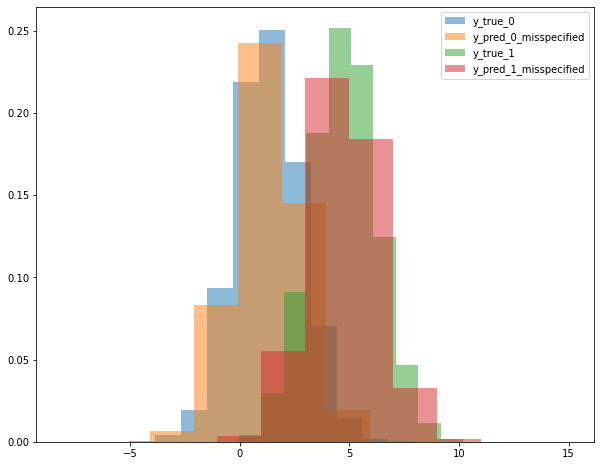

In [34]:
# Extract ground truth and predicted component memberships.
component_true = df["Component ID"].values
component_pred_misspecified_hmc = misspecified_model_idata_hmc.posterior.component_id_pred.values.flatten()

# Extract ground truth values for each mixture component.
y_true_0 = df[df["Component ID"] == 0]["Ground truth"].values
y_true_1 = df[df["Component ID"] == 1]["Ground truth"].values

# Extract predicted values for each mixture component.
y_pred_misspecified_hmc = misspecified_model_idata_hmc.posterior.y_posterior_pred.values
y_pred_misspecified_hmc = y_pred_misspecified_hmc.flatten()
y_pred_0_misspecified_hmc = y_pred_misspecified_hmc[~component_pred_misspecified_hmc.astype(bool)]
y_pred_1_misspecified_hmc = y_pred_misspecified_hmc[component_pred_misspecified_hmc.astype(bool)]

# Plot ground truth vs predictions for each mixture component.
plt.rcParams["figure.figsize"] = (10,8)
plt.hist(y_true_0, alpha = 0.5, label = "y_true_0", density = True)
plt.hist(y_pred_0_misspecified_hmc, alpha = 0.5, label = "y_pred_0_misspecified", density = True)
plt.hist(y_true_1, alpha = 0.5, label = "y_true_1", density = True)
plt.hist(y_pred_1_misspecified_hmc, alpha = 0.5, label = "y_pred_1_misspecified", density = True)
plt.legend(loc = "upper right")
plt.show()

In [35]:
np.unique(component_pred_misspecified_hmc, return_counts = True)

(array([0., 1.]), array([49685113, 50314887]))

#### Variational inference

In [36]:
# Extract ADVI results.
posterior_cols = []
for col in misspecified_model_fit_advi.variational_sample_pd.columns:
    if "posterior" in col:
        posterior_cols.append(col)

component_cols = []
for col in misspecified_model_fit_advi.variational_sample_pd.columns:
    if "component" in col:
        component_cols.append(col)

print(len(posterior_cols))
print(len(component_cols))

advi_posterior_pred = misspecified_model_fit_advi.variational_sample_pd[posterior_cols].to_numpy().flatten()
advi_component_pred = misspecified_model_fit_advi.variational_sample_pd[component_cols].to_numpy().flatten()
print(advi_posterior_pred.shape)
print(advi_posterior_pred[:10])
print(advi_component_pred.shape)
print(advi_component_pred[:10])

10000
10000
(50000000,)
[ 5.1977    3.2757    3.20637   3.32904   2.54498  -0.358666  3.49882
  5.60744   1.93246   2.04951 ]
(50000000,)
[1. 1. 1. 1. 0. 0. 1. 1. 1. 0.]


,lp__,log_p__,log_g__,mu[1],mu[2],sigma,theta
0,0.0,0.0,0.0,1.29725,4.72574,1.44025,0.507425


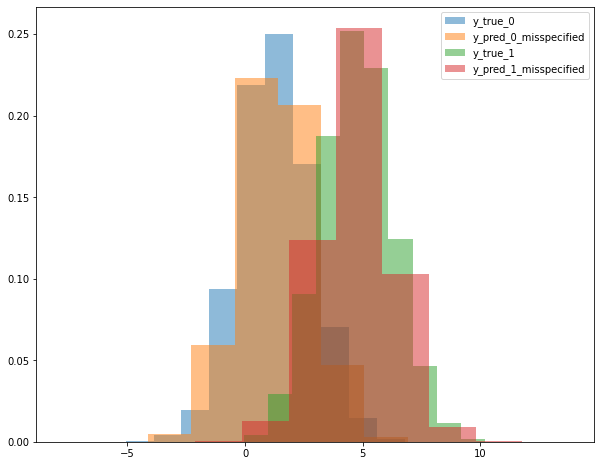

In [37]:
# View parameters as estimated by ADVI.
display(misspecified_model_fit_advi.variational_params_pd[["lp__", "log_p__", "log_g__", "mu[1]", "mu[2]", "sigma", "theta"]])

# Extract ground truth and predicted component memberships.
component_true = df["Component ID"].values
component_pred_misspecified_advi = advi_component_pred

# Extract ground truth values for each mixture component.
y_true_0 = df[df["Component ID"] == 0]["Ground truth"].values
y_true_1 = df[df["Component ID"] == 1]["Ground truth"].values

# Extract predicted values for each mixture component.
y_pred_misspecified_advi = advi_posterior_pred
y_pred_0_misspecified_advi = y_pred_misspecified_advi[~component_pred_misspecified_advi.astype(bool)]
y_pred_1_misspecified_advi = y_pred_misspecified_advi[component_pred_misspecified_advi.astype(bool)]

# Plot ground truth vs predictions for each mixture component.
plt.rcParams["figure.figsize"] = (10,8)
plt.hist(y_true_0, alpha = 0.5, label = "y_true_0", density = True)
plt.hist(y_pred_0_misspecified_advi, alpha = 0.5, label = "y_pred_0_misspecified", density = True)
plt.hist(y_true_1, alpha = 0.5, label = "y_true_1", density = True)
plt.hist(y_pred_1_misspecified_advi, alpha = 0.5, label = "y_pred_1_misspecified", density = True)
plt.legend(loc = "upper right")
plt.show()

#### MCMC vs VI

In [40]:
round_by = 3

# Compare predicted component means to ground truth.
mu_0_pred_misspecified_hmc = [i[:,0] for i in misspecified_model_idata_hmc.posterior.mu.values]
mu_0_pred_misspecified_hmc = np.array(mu_0_pred_misspecified_hmc).flatten()
mu_1_pred_misspecified_hmc = [i[:,1] for i in misspecified_model_idata_hmc.posterior.mu.values]
mu_1_pred_misspecified_hmc = np.array(mu_1_pred_misspecified_hmc).flatten()

print("\n-*- Component 0 -*-")
print("True mean      :", mu[0])
print("HMC-NUTS mean  : {} (SD = {})".format(round(mu_0_pred_misspecified_hmc.mean(), round_by), 
                                             round(mu_0_pred_misspecified_hmc.std(), round_by)))
print("ADVI mean      : {} (SD = {})".format(round(misspecified_model_fit_advi.variational_sample_pd["mu[1]"].mean(), round_by), 
                                             round(misspecified_model_fit_advi.variational_sample_pd["mu[1]"].std(), round_by)))

print("\n-*- Component 1 -*-")
print("True mean      :", mu[1])
print("HMC-NUTS mean  : {} (SD = {})".format(round(mu_1_pred_misspecified_hmc.mean(), round_by), 
                                             round(mu_1_pred_misspecified_hmc.std(), round_by)))
print("ADVI mean      : {} (SD = {})".format(round(misspecified_model_fit_advi.variational_sample_pd["mu[2]"].mean(), round_by), 
                                             round(misspecified_model_fit_advi.variational_sample_pd["mu[2]"].std(), round_by)))


-*- Component 0 -*-
True mean      : 1.25
HMC-NUTS mean  : 1.273 (SD = 0.035)
ADVI mean      : 1.297 (SD = 0.027)

-*- Component 1 -*-
True mean      : 4.75
HMC-NUTS mean  : 4.76 (SD = 0.035)
ADVI mean      : 4.726 (SD = 0.027)


## Compare correctly and incorrectly specified models

In [39]:
print("\n----- HMC-NUTS -----\n")

print("-*- Component 0 -*-")
print("True mean                :", mu[0])
print("Correctly specified mean : {} (SD = {})".format(round(mu_0_pred_correct_hmc.mean(), round_by), 
                                                       round(mu_0_pred_correct_hmc.std(), round_by)))
print("Misspecified mean        : {} (SD = {})".format(round(mu_0_pred_misspecified_hmc.mean(), round_by), 
                                                       round(mu_0_pred_misspecified_hmc.std(), round_by)))
print("\n-*- Component 1 -*-")
print("True mean                :", mu[1])
print("Correctly specified mean : {} (SD = {})".format(round(mu_1_pred_correct_hmc.mean(), round_by), 
                                                       round(mu_1_pred_correct_hmc.std(), round_by)))
print("Misspecified mean        : {} (SD = {})".format(round(mu_1_pred_misspecified_hmc.mean(), round_by), 
                                                       round(mu_1_pred_misspecified_hmc.std(), round_by)))

print("\n----- ADVI -----\n")

print("-*- Component 0 -*-")
print("True mean                :", mu[0])
print("Correctly specified mean : {} (SD = {})".format(round(correct_model_fit_advi.variational_sample_pd["mu[1]"].mean(), round_by), 
                                                       round(correct_model_fit_advi.variational_sample_pd["mu[1]"].std(), round_by)))
print("Misspecified mean        : {} (SD = {})".format(round(misspecified_model_fit_advi.variational_sample_pd["mu[1]"].mean(), round_by), 
                                                       round(misspecified_model_fit_advi.variational_sample_pd["mu[1]"].std(), round_by)))

print("\n-*- Component 1 -*-")
print("True mean                :", mu[1])
print("Correctly specified mean : {} (SD = {})".format(round(correct_model_fit_advi.variational_sample_pd["mu[2]"].mean(), round_by), 
                                                       round(correct_model_fit_advi.variational_sample_pd["mu[2]"].std(), round_by)))
print("Misspecified mean        : {} (SD = {})".format(round(misspecified_model_fit_advi.variational_sample_pd["mu[2]"].mean(), round_by), 
                                                       round(misspecified_model_fit_advi.variational_sample_pd["mu[2]"].std(), round_by)))


----- HMC-NUTS -----

-*- Component 0 -*-
True mean                : 1.25
Correctly specified mean : 1.273 (SD = 0.035)
Misspecified mean        : 1.273 (SD = 0.035)

-*- Component 1 -*-
True mean                : 4.75
Correctly specified mean : 4.764 (SD = 0.035)
Misspecified mean        : 4.76 (SD = 0.035)

----- ADVI -----

-*- Component 0 -*-
True mean                : 1.25
Correctly specified mean : 1.25 (SD = 0.026)
Misspecified mean        : 1.297 (SD = 0.027)

-*- Component 1 -*-
True mean                : 4.75
Correctly specified mean : 4.781 (SD = 0.025)
Misspecified mean        : 4.726 (SD = 0.027)


## Reproducing Figure 2 from Wang and Blei (2020)

This experiment is meant to reproduce the Figure 2 in the main text of this paper.

## The model misspecification error dominates the VI approximation error

This experiment is meant to provide empirical support for the proof in section *C.2 Component misspecification in Bayesian mixture models* from the  appendix. This proof shows that the model misspecification error dominates the VI approximation error in the VI posterior predictive distribution.

## End of document